Generating Tabular Data using GANs

In [13]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 865.8 kB/s eta 0:00:00a 0:00:01


In [19]:
!pip install tensorflow

  Using cached tensorflow-2.19.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached absl_py-2.3.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached grpcio-1.73.0-cp312-cp312-macosx_11_0_universal2.whl.metadata (3.8 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-macosx_10_9_universal2.whl.metadata (21 kB)
  Using cached namex-0.1.0-py3-none-any.whl.me

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle

np.random.seed(1635848)

In [68]:

class cGAN():
    """
    Class containing 3 methods (and __init__): generator, discriminator and train.
    Generator is trained using random noise and label as inputs. Discriminator is trained
    using real/fake samples and labels as inputs.
    """

    def __init__(self, latent_dim=32, out_shape=14):

        """
        This function sets up the whole system. It builds two main parts:

        The generator that makes fake data.

        The discriminator that tries to tell real data from fake data.
        It also connects these two parts for training.
        """
        
        self.latent_dim = latent_dim
        self.out_shape = out_shape
        self.num_classes = 2

        # Separate optimizer instances for discriminator and combined model
        optimizer_d = Adam(0.0002, 0.5)
        optimizer_g = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer_d,
                                   metrics=['accuracy'])

        # Build the generator
        self.generator = self.generator()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])

        # Freeze discriminator's weights when training the generator via combined model
        self.discriminator.trainable = False
        valid = self.discriminator([gen_samples, label])

        # Combined model (stack generator and discriminator)
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss='binary_crossentropy',
                              optimizer=optimizer_g,
                              metrics=['accuracy'])

    def generator(self):

        """
        This builds the generator model.

       The generator’s job is to create fake data that looks real.

       It starts with random noise (random numbers) as input.

       It also takes a label input (like class 0 or 1), which tells the generator what kind of data to create.

       The label is converted into a special form called an embedding (a way for the model to understand the label as numbers).

       The generator combines this noise and label info, then passes it through several layers (Dense layers with activation functions) that learn how to create realistic fake data matching the label.

       Finally, it outputs the generated fake data.

        """
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)

        return Model([noise, label], gen_sample, name="Generator")

    def discriminator(self):

        """
        This builds the discriminator model.

        The discriminator’s job is to look at data and decide: “Is this real or fake?”

        It takes as input some data samples (either real data or fake data from the generator).

        It also takes a label input (same as the generator’s labels), which helps it know which class the data should belong to.

        Like the generator, it converts the label into an embedding and combines it with the input data.

        Then it passes this combined info through layers to learn how to distinguish real from fake samples.

        At the end, it outputs a number close to 1 if it thinks the data is real, or close to 0 if it thinks the data is fake.
        """
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(512, input_dim=self.out_shape, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(256, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(128, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(1, activation='sigmoid'))

        gen_sample = Input(shape=(self.out_shape,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))

        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input)

        return Model(inputs=[gen_sample, label], outputs=validity, name="Discriminator")

    def train(self, X_train, y_train, pos_index, neg_index, epochs, sampling=False, batch_size=32, sample_interval=100, plot=True):

        """

        This is where the GAN actually learns over many steps (called epochs).

        Each step:

        Pick real data samples from the training set, and their labels.

        Generate fake data samples using the generator, with random noise and random labels.

       Train the discriminator with both real and fake data, teaching it to tell real from fake better.

      Then train the generator by making the discriminator believe that the fake samples are real (the generator wants to fool the discriminator).

      It uses some tricks like label smoothing to make training more stable.

     The generator and discriminator take turns improving, pushing each other to get better — the generator makes more realistic fakes, and the discriminator gets better at spotting fakes.

     This repeats for many epochs, and you can watch the losses decrease as the models improve.

        """
        global G_losses
        global D_losses

        G_losses = []
        D_losses = []

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            if sampling:
                idx1 = np.random.choice(pos_index, 8)
                idx0 = np.random.choice(neg_index, batch_size - 8)
                idx = np.concatenate((idx1, idx0))
            else:
                idx = np.random.choice(len(y_train), batch_size)

            samples, labels = X_train[idx], y_train[idx]
            samples, labels = shuffle(samples, labels)

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_samples = self.generator.predict([noise, labels])

            if epoch < epochs // 1.5:
                valid_smooth = (valid + 0.1) - (np.random.random(valid.shape) * 0.1)
                fake_smooth = (fake - 0.1) + (np.random.random(fake.shape) * 0.1)
            else:
                valid_smooth = valid
                fake_smooth = fake

            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)

            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            if (epoch + 1) % sample_interval == 0:
                print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch + 1, epochs, d_loss[0], g_loss[0]))

            G_losses.append(g_loss[0])
            D_losses.append(d_loss[0])

        if plot:
            plt.figure(figsize=(10, 5))
            plt.title("Generator and Discriminator Loss")
            plt.plot(G_losses, label="G")
            plt.plot(D_losses, label="D")
            plt.xlabel("iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()

Adult Census Income Dataset
First dataset has 15 features including one class that we will try to predict (income). Dataset contains a lot of categorical features that need some preprocessing before feeding it into the algorithm.

In [70]:
import pandas as pd

df = pd.read_csv(os.path.join(path, "adult.csv"))
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Before employing any algorithms, we will first preprocess some data.

In [72]:
le = preprocessing.LabelEncoder()
for i in ['workclass','education','marital.status','occupation','relationship','race','sex','native.country','income']:
    df[i] = le.fit_transform(df[i].astype(str))

"""
This code converts words into numbers so that the machine learning model can understand them

"""

In [74]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,0,77053,11,9,6,0,1,4,0,0,4356,40,39,0
1,82,4,132870,11,9,6,4,1,4,0,0,4356,18,39,0
2,66,0,186061,15,10,6,0,4,2,0,0,4356,40,39,0
3,54,4,140359,5,4,0,7,4,4,0,0,3900,40,39,0
4,41,4,264663,15,10,5,10,3,4,0,0,3900,40,39,0


In [76]:
df.income.value_counts()

income
0    24720
1     7841
Name: count, dtype: int64

Splitting the dataframe

In [78]:
scaler = StandardScaler()

X = scaler.fit_transform(df.drop('income', axis=1))
y = df['income'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Classifying using real trainset

[LightGBM] [Info] Number of positive: 6251, number of negative: 19797
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239980 -> initscore=-1.152789
[LightGBM] [Info] Start training from score -1.152789
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4923
           1       0.78      0.65      0.71      1590

    accuracy                           0.87      6513
   macro avg       0.84      0.80      0.81      6513
weighted avg       0.87      0.87      0.87      6513



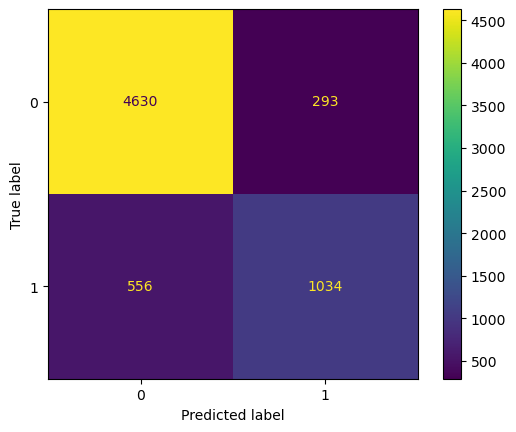

In [80]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train, y_train)

y_pred = lgb_1.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(lgb_1, X_test, y_test)
plt.show()

Training cGAN

In [82]:
cgan = cGAN()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [84]:
import tensorflow
tensorflow.config.run_functions_eagerly(True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/opt/anaconda3/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

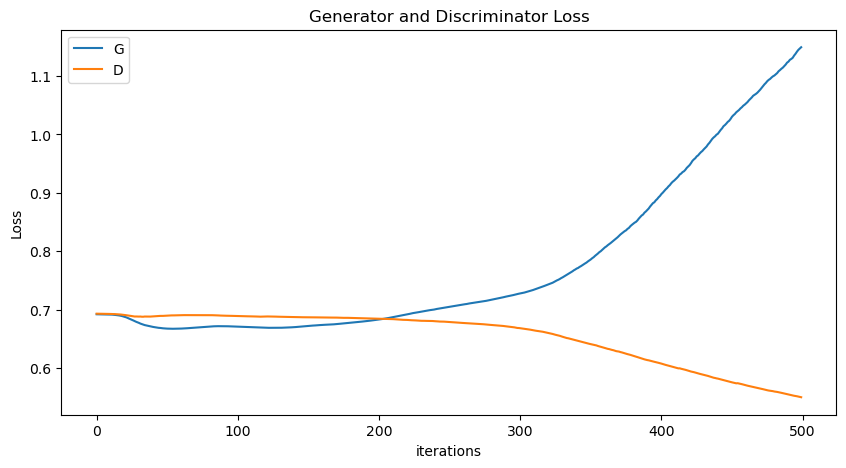

In [86]:
y_train = y_train.reshape(-1,1)
pos_index = np.where(y_train==1)[0]
neg_index = np.where(y_train==0)[0]
cgan.train(X_train, y_train, pos_index, neg_index, epochs=500)

Generating new instances

In [91]:
# we want to generate 19758 instances with class value 0 since that represents how many 0s are in the label of the real training set
noise = np.random.normal(0, 1, (19758, 32))
sampled_labels = np.zeros(19758).reshape(-1, 1)


gen_samples = cgan.generator.predict([noise, sampled_labels])

gen_df = pd.DataFrame(data = gen_samples,
                      columns = df.drop('income',axis=1).columns)

 54/618 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

/opt/anaconda3/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [93]:
# we want to generate 6290 instances with class value 1 since that represents how many 1s are in the label of the real training set
noise_2 = np.random.normal(0, 1, (6290, 32))
sampled_labels_2 = np.ones(6290).reshape(-1, 1)


gen_samples_2 = cgan.generator.predict([noise_2, sampled_labels_2])

gen_df_2 = pd.DataFrame(data = gen_samples_2,
                      columns = df.drop('income',axis=1).columns)

 29/197 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/opt/anaconda3/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Combining generated instances into a dataframe

In [98]:
gen_df_2['income'] = 1
gen_df['income']=0

df_gan = pd.concat([gen_df_2, gen_df], ignore_index=True, sort=False)
df_gan = df_gan.sample(frac=1).reset_index(drop=True)

X_train_2 = df_gan.drop('income', axis=1)
y_train_2 = df_gan['income'].values

Classifying testset using generated trainset

[LightGBM] [Info] Number of positive: 6290, number of negative: 19758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.241477 -> initscore=-1.144597
[LightGBM] [Info] Start training from score -1.144597
              precision    recall  f1-score   support

           0       0.78      0.49      0.60      4923
           1       0.27      0.57      0.36      1590

    accuracy                           0.51      6513
   macro avg       0.52      0.53      0.48      6513
weighted avg       0.66      0.51      0.55      6513



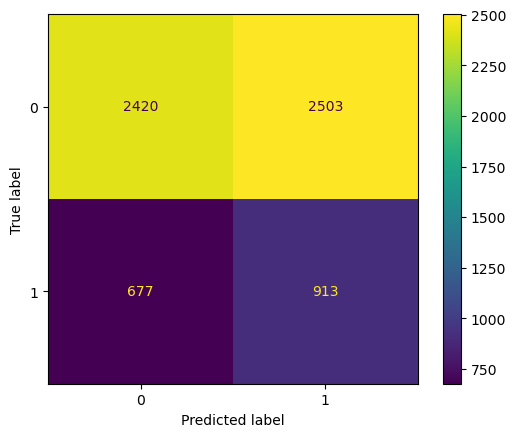

In [105]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train_2, y_train_2)


y_pred = lgb_1.predict(X_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(lgb_1, X_test, y_test)
plt.show()